In [1]:
import os
import json

import cv2
import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121, MobileNetV2
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam, Nadam
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
#PATHS
TRAIN_IMGS = '../input/severstal-steel-defect-detection/train_images'
TEST_IMGS = '../input/severstal-steel-defect-detection/test_images/'
TEMP_TRAIN = '../tmp/train'

def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_path(TEMP_TRAIN)

In [3]:
train_df = pd.read_csv('../input/editeddata/maskCount_df.csv')
train_df['noDefect'] = (train_df['hasMask'] == 0).astype(int)

In [4]:
def resize_img(imageid, path, size):
    path = f'{path}/{imageid}'
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img

for imageid in tqdm(train_df['ImageId']):
    img = resize_img(imageid, path = TRAIN_IMGS, size = (256, 256))
    cv2.imwrite(f'{TEMP_TRAIN}/{imageid}', img)

100%|██████████| 12568/12568 [02:46<00:00, 75.55it/s]


In [5]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.,
        validation_split=0.15
    )
def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        train_df, 
        directory=TEMP_TRAIN,
        x_col='ImageId', 
        y_col='noDefect', 
        class_mode='raw',
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        subset=subset
    )

In [6]:
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')

Found 10683 validated image filenames.
Found 1885 validated image filenames.


In [7]:
def build_model():
    mobilenet = MobileNetV2(
        include_top=False,
        input_shape=(256,256,3),
        weights=(
            '../input/'
            'mobilenet-v2-keras-weights/'
            'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
        )
    )
    
    model = Sequential()
    model.add(mobilenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    return model

In [8]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_256 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [9]:
total_steps = train_df.shape[0] / BATCH_SIZE

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_lr=1e-6
)
checkpoint = ModelCheckpoint(
    'cls-model-mobilenetv2.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
history = model.fit_generator(
    train_gen,
    steps_per_epoch=total_steps * 0.85,
    validation_data=val_gen,
    validation_steps=total_steps * 0.15,
    epochs=40,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/40
334/333 [==============================] - 195s 585ms/step - loss: 0.3784 - acc: 0.8334 - val_loss: 2.4270 - val_acc: 0.5581

Epoch 00001: val_acc improved from -inf to 0.55809, saving model to cls-model-mobilenetv2.h5
Epoch 2/40
334/333 [==============================] - 175s 524ms/step - loss: 0.2859 - acc: 0.8830 - val_loss: 2.6260 - val_acc: 0.4716

Epoch 00002: val_acc did not improve from 0.55809
Epoch 3/40
334/333 [==============================] - 176s 528ms/step - loss: 0.2553 - acc: 0.8947 - val_loss: 1.1369 - val_acc: 0.7910

Epoch 00003: val_acc improved from 0.55809 to 0.79098, saving model to cls-model-mobilenetv2.h5
Epoch 4/40
334/333 [==============================] - 176s 526ms/step - loss: 0.2308 - acc: 0.9065 - val_loss: 1.7099 - val_acc: 0.7326

Epoch 00004: val_acc did not improve from 0.79098
Epoch 5/40
334/333 [==============================] - 175s 525ms/step - loss: 0.2175 - acc: 0.9146 - val_loss: 3.6069 - val_acc: 0.3804

Epoch 00005: val_acc did n

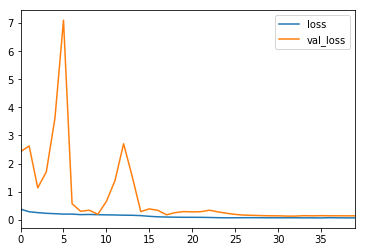

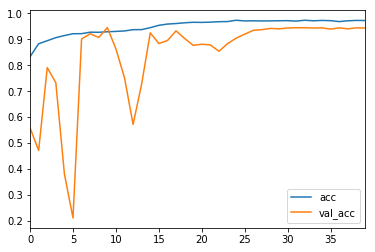

In [10]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()